In [1]:
customer_df <- read.csv('Wholesale_customers_data.csv')
customer_df$Channel <- NULL
customer_df$Region <- NULL
dim(customer_df)

[1] 440   6

# Correlation and Redundancy

I claim that there is correlation and redundancy in the `customer` table. What I mean by this is that some features are linear combinations of other features. 

Let's examine redundancy by dropping a feature and seeing if the other features can predict it.

In [2]:
install.packages('rpart')

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [3]:
library(caret)
library(rpart)

Loading required package: lattice
Loading required package: ggplot2


In [4]:
calculate_r_2 <- function(actual, prediction) {
    return (1 - (sum((actual-prediction)^2)/sum((actual-mean(actual))^2)))
}

calculate_r_2_for_feature <- function(data, feature) {
    n <- nrow(data)
    
    train_index <- sample(seq_len(n), size = 0.8*n)

    train <- data[train_index,]
    test <- data[-train_index,]
    
    this_formula = paste(feature,"~.")
    fit <- rpart(data=train, formula=as.formula(this_formula))

    y_test <- as.vector(test[[feature]])
    test[feature] <- NULL
    predictions <- predict(fit, test)
    return (calculate_r_2(y_test, predictions))
}

In [5]:
calculate_r_2_for_feature(customer_df,'Detergents_Paper')

[1] 0.390474

In [6]:
print(paste("Delicatessen: ", calculate_r_2_for_feature(customer_df,'Delicatessen')))
print(paste("Degergents_paper: ", calculate_r_2_for_feature(customer_df,'Detergents_Paper')))
print(paste("Fresh: ", calculate_r_2_for_feature(customer_df,'Fresh')))
print(paste("Frozen: ", calculate_r_2_for_feature(customer_df,'Frozen')))
print(paste("Grocery: ", calculate_r_2_for_feature(customer_df,'Grocery')))
print(paste("Milk: ", calculate_r_2_for_feature(customer_df,'Milk')))

[1] "Delicatessen:  0.135683947847623"
[1] "Degergents_paper:  0.66733549576951"
[1] "Fresh:  -0.414610728416872"
[1] "Frozen:  -0.186768829392491"
[1] "Grocery:  0.68813369765192"
[1] "Milk:  0.639886611898684"


But this is subject to randomness. There is randomness in my `train_test_split`. Let's do the whole thing many times and take the average. 

In [7]:
mean_r2_for_feature <- function (data, feature) {
    scores = c()
    for (i in 1:100) {
        scores = c(scores, calculate_r_2_for_feature(data, feature))
    }
    
    return (mean(scores))
}

In [8]:
print(paste("Delicatessen: ", mean_r2_for_feature(customer_df,'Delicatessen')))
print(paste("Detergents_Paper: ", mean_r2_for_feature(customer_df,'Detergents_Paper')))
print(paste("Fresh: ", mean_r2_for_feature(customer_df,'Fresh')))
print(paste("Frozen: ", mean_r2_for_feature(customer_df,'Frozen')))
print(paste("Grocery: ", mean_r2_for_feature(customer_df,'Grocery')))
print(paste("Milk: ", mean_r2_for_feature(customer_df,'Milk')))

[1] "Delicatessen:  -0.411509816623066"
[1] "Detergents_Paper:  0.682225503364799"
[1] "Fresh:  -0.0390401210321497"
[1] "Frozen:  -0.169612822832042"
[1] "Grocery:  0.710613000285535"
[1] "Milk:  0.328815435785094"


In [9]:
print(paste("Delicatessen: ", mean_r2_for_feature(customer_df,'Delicatessen')))
print(paste("Detergents_Paper: ", mean_r2_for_feature(customer_df,'Detergents_Paper')))
print(paste("Fresh: ", mean_r2_for_feature(customer_df,'Fresh')))
print(paste("Frozen: ", mean_r2_for_feature(customer_df,'Frozen')))
print(paste("Grocery: ", mean_r2_for_feature(customer_df,'Grocery')))
print(paste("Milk: ", mean_r2_for_feature(customer_df,'Milk')))

[1] "Delicatessen:  -0.324812654995921"
[1] "Detergents_Paper:  0.718361568909339"
[1] "Fresh:  -0.033008936782851"
[1] "Frozen:  -0.142142989038062"
[1] "Grocery:  0.713980028507445"
[1] "Milk:  0.340088369891967"


#### Discussion

What does this tell us?

## Visualize Redundancy

Study the correlation of the data.

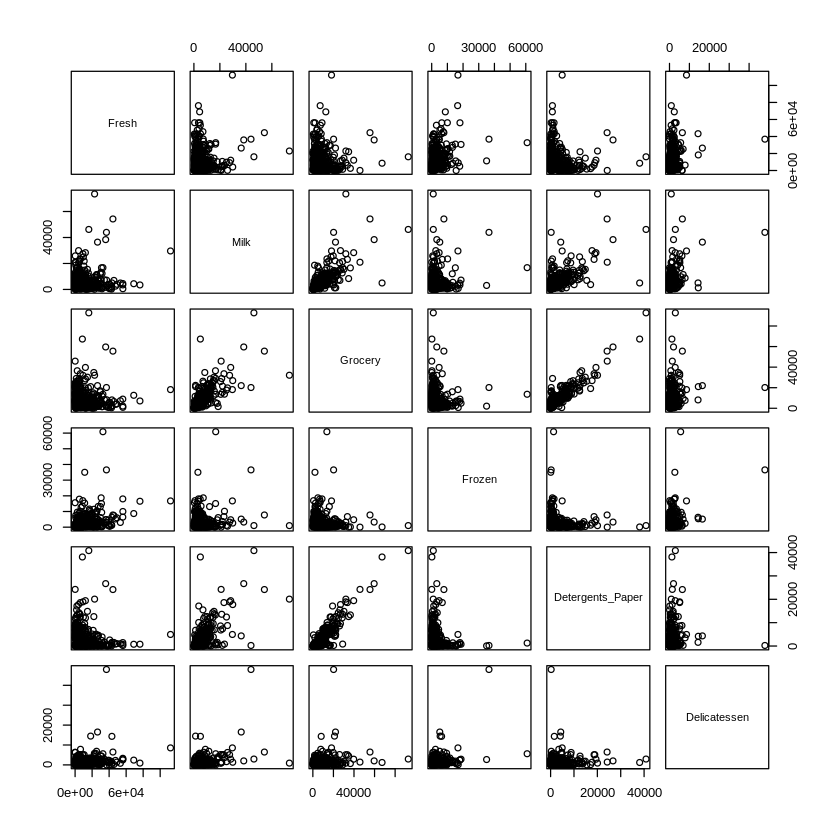

In [10]:
pairs(customer_df)

In [11]:
cor(customer_df)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Fresh,1.00000000,0.1005098,-0.01185387,0.34588146,-0.1019529,0.2446900
Milk,0.10050977,1.0000000,0.72833512,0.12399376,0.6618157,0.4063683
Grocery,-0.01185387,0.7283351,1.00000000,-0.04019274,0.9246407,0.2054965
Frozen,0.34588146,0.1239938,-0.04019274,1.00000000,-0.1315249,0.3909475
Detergents_Paper,-0.10195294,0.6618157,0.92464069,-0.13152491,1.0000000,0.0692913
Delicatessen,0.24468997,0.4063683,0.20549651,0.39094747,0.0692913,1.0000000


In [12]:
library(reshape2)
cormat = cor(customer_df)

In [13]:
cormat[lower.tri(cormat)] <- NA

In [14]:
melted_cormat <- melt(cormat, na.rm = T)

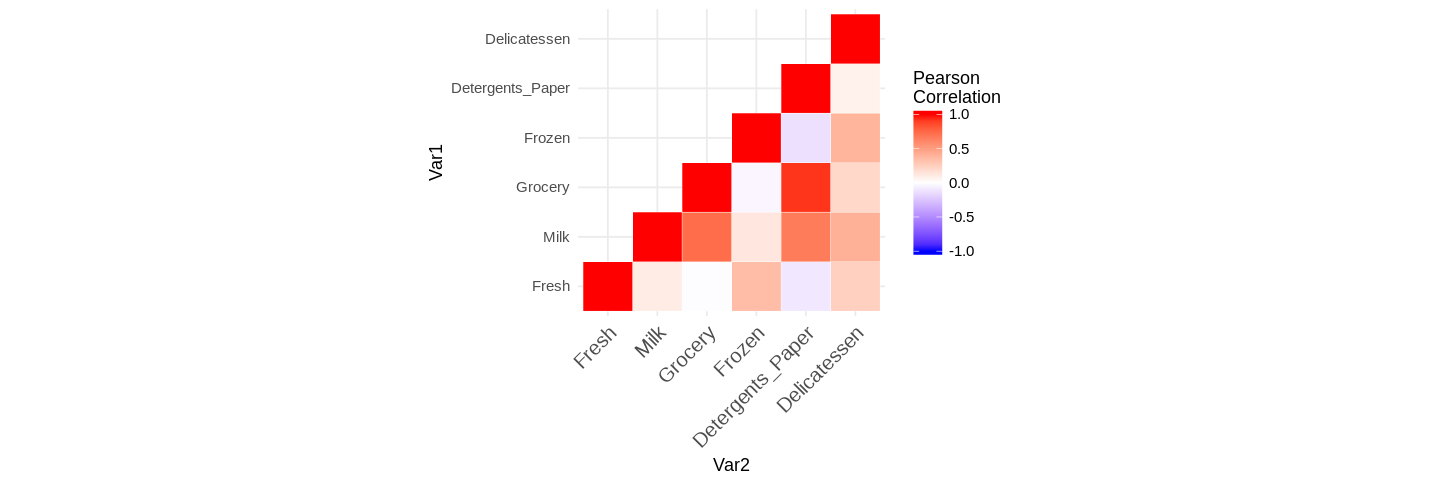

In [16]:
library(ggplot2)
library(repr)
options(repr.plot.width=12, repr.plot.height=4)
ggplot(data = melted_cormat, aes(Var2, Var1, fill = value))+
 geom_tile(color = "white")+
 scale_fill_gradient2(low = "blue", high = "red", mid = "white", 
   midpoint = 0, limit = c(-1,1), space = "Lab", 
   name="Pearson\nCorrelation") +
  theme_minimal()+ 
 theme(axis.text.x = element_text(angle = 45, vjust = 1, 
    size = 12, hjust = 1))+
 coord_fixed()